### Importing Libraries

In [1]:
import os
from IPython import display
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array

2024-04-22 11:20:37.076419: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 11:20:37.259668: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-22 11:20:38.009690: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/student/anaconda3/envs/tensorflow/lib/python3.10/site-packages/cv2/../../lib64:/h

### Data Processing

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-04-22 10:15:01.930865: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-22 10:15:02.012345: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-22 10:15:02.012464: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
data_dir = "Stage_4"

img_width, img_height = 224, 224 # 224 for DCGAN
batch_size = 32

# Load all images from the folder
def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img = load_img(os.path.join(folder_path, filename), target_size=(img_width, img_height))
        img_array = img_to_array(img)
        img_tensor = tf.convert_to_tensor(img_array)
        images.append(img_tensor)
    return np.array(images)

# Load images from the folder
train = load_images_from_folder(data_dir)

In [4]:
train

array([[[[ 81.,  81.,  81.],
         [ 83.,  83.,  83.],
         [ 86.,  86.,  86.],
         ...,
         [ 90.,  90.,  90.],
         [ 87.,  87.,  87.],
         [ 88.,  88.,  88.]],

        [[ 81.,  81.,  81.],
         [ 83.,  83.,  83.],
         [ 87.,  87.,  87.],
         ...,
         [ 90.,  90.,  90.],
         [ 89.,  89.,  89.],
         [ 89.,  89.,  89.]],

        [[ 80.,  80.,  80.],
         [ 84.,  84.,  84.],
         [ 87.,  87.,  87.],
         ...,
         [ 91.,  91.,  91.],
         [ 90.,  90.,  90.],
         [ 88.,  88.,  88.]],

        ...,

        [[139., 139., 139.],
         [140., 140., 140.],
         [146., 146., 146.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[135., 135., 135.],
         [134., 134., 134.],
         [145., 145., 145.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[137., 137., 137.],
       

In [5]:
train = (train - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [6]:
train

array([[[[-0.3647059 , -0.3647059 , -0.3647059 ],
         [-0.34901962, -0.34901962, -0.34901962],
         [-0.3254902 , -0.3254902 , -0.3254902 ],
         ...,
         [-0.29411766, -0.29411766, -0.29411766],
         [-0.31764707, -0.31764707, -0.31764707],
         [-0.30980393, -0.30980393, -0.30980393]],

        [[-0.3647059 , -0.3647059 , -0.3647059 ],
         [-0.34901962, -0.34901962, -0.34901962],
         [-0.31764707, -0.31764707, -0.31764707],
         ...,
         [-0.29411766, -0.29411766, -0.29411766],
         [-0.3019608 , -0.3019608 , -0.3019608 ],
         [-0.3019608 , -0.3019608 , -0.3019608 ]],

        [[-0.37254903, -0.37254903, -0.37254903],
         [-0.34117648, -0.34117648, -0.34117648],
         [-0.31764707, -0.31764707, -0.31764707],
         ...,
         [-0.28627452, -0.28627452, -0.28627452],
         [-0.29411766, -0.29411766, -0.29411766],
         [-0.30980393, -0.30980393, -0.30980393]],

        ...,

        [[ 0.09019608,  0.09019608,  0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


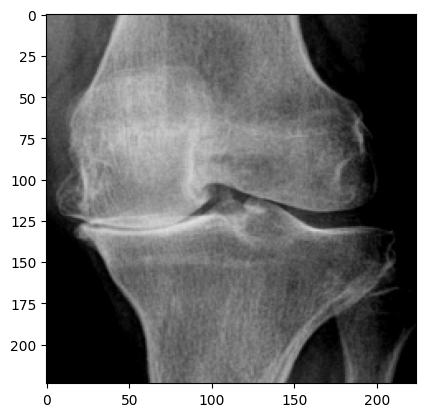

In [7]:
plt.imshow(train[2])

In [8]:
train.shape

(536, 224, 224, 3)

### DCGAN - Tensorflow

In [9]:
# # Generator
# def build_generator(latent_dim):
#     input_noise = Input(shape=(latent_dim,))
#     x = Dense(7*7*256)(input_noise)
#     x = Reshape((7, 7, 256))(x)
#     x = Conv2DTranspose(128, kernel_size=5, strides=4, padding='same')(x)  # Adjust the strides to upscale to 28x28
#     x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.01)(x)
#     x = Conv2DTranspose(64, kernel_size=5, strides=4, padding='same')(x)  # Adjust the strides to upscale to 112x112
#     x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.01)(x)
#     x = Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', activation='tanh')(x)  # Adjust the strides to upscale to 224x224
#     generator = Model(input_noise, x)
#     return generator

# # Discriminator
# def build_discriminator(input_shape):
#     input_image = Input(shape=input_shape)
#     x = Conv2D(64, kernel_size=5, strides=2, padding='same')(input_image)
#     x = LeakyReLU(alpha=0.01)(x)
#     x = Conv2D(128, kernel_size=5, strides=2, padding='same')(x)
#     x = LeakyReLU(alpha=0.01)(x)
#     x = Flatten()(x)
#     x = Dense(1, activation='sigmoid')(x)
#     discriminator = Model(input_image, x)
#     return discriminator

# # Combined model
# def build_dcgan(generator, discriminator):
#     discriminator.trainable = False
#     input_noise = Input(shape=(latent_dim,))
#     generated_image = generator(input_noise)
#     validity = discriminator(generated_image)
#     dcgan = Model(input_noise, validity)
#     return dcgan

# # Define the input shape and latent dimension
# input_shape = (224, 224, 1)
# latent_dim = 100

# # Build the generator, discriminator, and DCGAN models
# generator = build_generator(latent_dim)
# discriminator = build_discriminator(input_shape)
# dcgan = build_dcgan(generator, discriminator)

# # Compile the discriminator and DCGAN models
# discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
# dcgan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

In [10]:
from keras.layers import Input, Dense, Reshape, Conv2D, Conv2DTranspose, Flatten, BatchNormalization, LeakyReLU
from keras.models import Model
from keras.optimizers import Adam

# Generator
def build_generator(latent_dim):
    input_noise = Input(shape=(latent_dim,))
    x = Dense(7*7*256)(input_noise)
    x = Reshape((7, 7, 256))(x)
    x = Conv2DTranspose(128, kernel_size=5, strides=4, padding='same')(x)  # Adjust the strides to upscale to 28x28
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Conv2DTranspose(64, kernel_size=5, strides=4, padding='same')(x)  # Adjust the strides to upscale to 112x112
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh')(x)  # Adjust the strides to upscale to 224x224 and output 3 channels
    generator = Model(input_noise, x)
    return generator

# Discriminator
def build_discriminator(input_shape):
    input_image = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=5, strides=2, padding='same')(input_image)
    x = LeakyReLU(alpha=0.01)(x)
    x = Conv2D(128, kernel_size=5, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(input_image, x)
    return discriminator

# Combined model
def build_dcgan(generator, discriminator):
    discriminator.trainable = False
    input_noise = Input(shape=(latent_dim,))
    generated_image = generator(input_noise)
    validity = discriminator(generated_image)
    dcgan = Model(input_noise, validity)
    return dcgan

# Define the input shape and latent dimension
input_shape = (224, 224, 3)  # Changed to 3 channels
latent_dim = 100

# Build the generator, discriminator, and DCGAN models
generator = build_generator(latent_dim)
discriminator = build_discriminator(input_shape)
dcgan = build_dcgan(generator, discriminator)

# Compile the discriminator and DCGAN models
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
dcgan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))


In [11]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(224, 224))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [16]:
epochs = 50
batch_size = 64

seed = tf.random.normal([16, 100])

# Train the DCGAN model
for epoch in range(epochs):
    for batch in range(train.shape[0] // batch_size):
        # Train the discriminator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_images = generator.predict(noise)
        real_images = train[np.random.randint(0, train.shape[0], batch_size)]
        
        discriminator_loss_real = discriminator.train_on_batch(real_images, np.ones(batch_size))
        discriminator_loss_fake = discriminator.train_on_batch(fake_images, np.zeros(batch_size))
        discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)
        
        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        generator_loss = dcgan.train_on_batch(noise, np.ones(batch_size))
    
    # Print the losses
    print(f"Epoch {epoch+1}/{epochs} - Discriminator Loss: {discriminator_loss} - Generator Loss: {generator_loss}")

2/2 [==============================] - 0s 202ms/step
Epoch 1/50 - Discriminator Loss: 1.4941549897193909 - Generator Loss: 0.0015208791010081768
2/2 [==============================] - 0s 199ms/step
Epoch 2/50 - Discriminator Loss: 1.5615603923797607 - Generator Loss: 0.0014268035301938653
2/2 [==============================] - 0s 203ms/step
Epoch 3/50 - Discriminator Loss: 1.6146489679813385 - Generator Loss: 0.001383577473461628
2/2 [==============================] - 0s 206ms/step
Epoch 4/50 - Discriminator Loss: 1.6894338726997375 - Generator Loss: 0.0013293165247887373
2/2 [==============================] - 0s 198ms/step
Epoch 5/50 - Discriminator Loss: 1.741690218448639 - Generator Loss: 0.0013100445503368974
2/2 [==============================] - 0s 214ms/step
Epoch 6/50 - Discriminator Loss: 1.8307473361492157 - Generator Loss: 0.0012697991915047169
2/2 [==============================] - 0s 195ms/step
Epoch 7/50 - Discriminator Loss: 1.8960366249084473 - Generator Loss: 0.0012056

In [ ]:
generate_and_save_images(generator, epochs, seed)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate random noise
num_samples =  16  # Number of images to generate
noise = np.random.normal(0, 1, (num_samples, latent_dim))  # latent_dim should match the dimensionality of your generator's input

# Generate images using the generator
generated_images = generator.predict(noise)

# Visualize the generated images
fig, axs = plt.subplots(4, 4)
fig.suptitle('Generated Images')
count = 0
for i in range(4):
    for j in range(4):
        axs[i, j].imshow(generated_images[count, :, :, 0], cmap='gray')  # Assuming grayscale images
        axs[i, j].axis('off')
        count += 1
plt.show()


In [9]:
# generator.save("Saved Models/Generator")
# discriminator.save("Saved Models/Discriminator")
# dcgan.save("Saved Models/DCGAN")

### DCGAN - PyTorch

In [5]:
import torch
torch.cuda.current_device()
# torch.cuda.get_device_name(device_ID)

0

In [9]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torchvision
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader
# import matplotlib.pyplot as plt

# # Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Define the Generator network
# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()
#         self.main = nn.Sequential(
#             # input is Z, going into a convolution
#             nn.ConvTranspose2d(100, 64 * 8, 4, 1, 0, bias=False),
#             nn.BatchNorm2d(64 * 8),
#             nn.ReLU(True),
#             # state size. (64*8) x 4 x 4
#             nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(64 * 4),
#             nn.ReLU(True),
#             # state size. (64*4) x 8 x 8
#             nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(64 * 2),
#             nn.ReLU(True),
#             # state size. (64*2) x 16 x 16
#             nn.ConvTranspose2d(64 * 2,    1, 4, 2, 1, bias=False),
#             nn.Tanh()
#             # state size. 1 x 32 x 32
#         )

#     def forward(self, input):
#         return self.main(input)

# # Define the Discriminator network
# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
#         self.main = nn.Sequential(
#             # input is (nc) x 32 x 32
#             nn.Conv2d(1, 64, 4, 2, 1, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (64) x 16 x 16
#             nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(64 * 2),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (64*2) x 8 x 8
#             nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(64 * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (64*4) x 4 x 4
#             nn.Conv2d(64 * 4, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid()
#         )

#     def forward(self, input):
#         return self.main(input)

# # Create the Generator and Discriminator networks
# netG = Generator().to(device)
# netD = Discriminator().to(device)

# # Setup Adam optimizers for both G and D
# optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
# optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

# # Configure data loader
# transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# dataset = datasets.ImageFolder(root='Dataset', transform=transform)
# dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# # Define real and fake labels
# real_label = 1.0
# fake_label = 0.0

# # Define the loss function
# criterion = nn.BCELoss()

# # Training Loop
# epochs = 10
# for epoch in range(epochs):
#     for i, data in enumerate(dataloader, 0):
#         ############################
#         # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
#         ###########################
#         ## Train with all-real batch
#         netD.zero_grad()
#         # Format batch
#         real_cpu = data[0].to(device)
#         b_size = real_cpu.size(0)
#         label = torch.full((b_size, 1, 1, 1), real_label, device=device)

#         # Forward pass real batch through D
#         output = netD(real_cpu)
#         # Calculate loss on all-real batch
#         errD_real = criterion(output, label)
#         # Calculate gradients for D in backward pass
#         errD_real.backward()
#         D_x = output.mean().item()

#         ## Train with all-fake batch
#         # Generate batch of latent vectors
#         noise = torch.randn(b_size, 100, 1, 1, device=device)
#         # Generate fake image batch with G
#         fake = netG(noise)
#         label.fill_(fake_label)
#         # Classify all fake batch with D
#         output = netD(fake.detach())
#         # Calculate D's loss on the all-fake batch
#         errD_fake = criterion(output, label)
#         # Calculate the gradients for this batch
#         errD_fake.backward()
#         D_G_z1 = output.mean().item()
#         # Add the gradients from the all-real and all-fake batches
#         errD = errD_real + errD_fake
#         # Update D
#         optimizerD.step()

#         ############################
#         # (2) Update G network: maximize log(D(G(z)))
#         ###########################
#         netG.zero_grad()
#         label.fill_(real_label)  # fake labels are real for generator cost
#         # Since we just updated D, perform another forward pass of all-fake batch through D
#         output = netD(fake)
#         # Calculate G's loss based on this output
#         errG = criterion(output, label)
#         # Calculate gradients for G
#         errG.backward()
#         D_G_z2 = output.mean().item()
#         # Update G
#         optimizerG.step()

#         # Output training stats
#     if epoch%1==0:
#        print(f"Epoch {epoch/epochs}, D Loss: {errD.item()}, G Loss: {errG.item()}")

#     # Save the model checkpoints
#     torch.save(netG.state_dict(), 'netG_epoch_%d.pth' % epoch)
#     torch.save(netD.state_dict(), 'netD_epoch_%d.pth' % epoch)

# # Generate some images after training
# noise = torch.randn(64, 100, 1, 1, device=device)
# fake_images = netG(noise)

# # Display the generated images
# plt.figure(figsize=(10,10))
# for i in range(64):
#     plt.subplot(8, 8, i+1)
#     plt.imshow(fake_images[i].cpu().detach().numpy().reshape(32,32), cmap='gray')
#     plt.axis('off')
# plt.show()

RuntimeError: Given groups=1, weight of size [64, 1, 4, 4], expected input[64, 3, 224, 224] to have 1 channels, but got 3 channels instead

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')

# Define the Generator network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(100, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # state size. (64*8) x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # state size. (64*4) x 8 x 8
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # state size. (64*2) x 16 x 16
            nn.ConvTranspose2d(64 * 2, 3, 4, 2, 1, bias=False),  # Changed output channels to 3 for RGB images
            nn.Tanh()
            # state size. 3 x 224 x 224
        )

    def forward(self, input):
        return self.main(input)

# Define the Discriminator network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 224 x 224
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),  # Changed input channels to 3 for RGB images
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (64) x 112 x 112
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (64*2) x 56 x 56
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (64*4) x 28 x 28
            nn.Conv2d(64 * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Create the Generator and Discriminator networks
netG = Generator().to(device)
netD = Discriminator().to(device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Configure data loader
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.ImageFolder(root='Dataset', transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define real and fake labels
real_label = 1.0
fake_label = 0.0

# Define the loss function
criterion = nn.BCELoss()

# Training Loop
epochs = 10
for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size, 1, 1, 1), real_label, device=device)

        # Forward pass real batch through D
        output = netD(real_cpu)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach())
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
    if epoch % 1 == 0:
        print(f"Epoch {epoch}/{epochs}, D Loss: {errD.item()}, G Loss: {errG.item()}")

    # Save the model checkpoints
    torch.save(netG.state_dict(), 'netG_epoch_%d.pth' % epoch)
    torch.save(netD.state_dict(), 'netD_epoch_%d.pth' % epoch)

# Generate some images after training
noise = torch.randn(64, 100, 1, 1, device=device)
fake_images = netG(noise)

# Display the generated images
plt.figure(figsize=(10, 10))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(fake_images[i].cpu().detach().permute(1, 2, 0).numpy() * 0.5 + 0.5)
    plt.axis('off')
plt.show()

ValueError: Using a target size (torch.Size([64, 1, 1, 1])) that is different to the input size (torch.Size([64, 1, 25, 25])) is deprecated. Please ensure they have the same size.